In [1]:
import sys
sys.path.append("../")
import PatternStructure as ps
import AssociativeNetwork as nt
from OrderParameterCalculator import OrderParameterCalculator
import functions as fs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
from tqdm import tqdm
sns.set(style='white',font_scale=1.5)

In [2]:
# PARAMETERS
GAMMA = 0.5
XI = 0.1
N_CELLS = 1000
N_PATTERNS = 64 # P
CELLS_PER_PATTERN = 100 
N_CHAINS = 2 # M
PATTERNS_PER_CHAIN = 2 # Q

DYNAMIC_SPARISTY = .2*(CELLS_PER_PATTERN/N_CELLS)

In [4]:
#Memory structure
kernel = ps.InteractionKernel(gamma=GAMMA,xi=XI)
memories = ps.PatternStructure(n_cells=N_CELLS,
                            n_patterns=N_PATTERNS,
                            cells_per_pattern=CELLS_PER_PATTERN,
                            n_chains=N_CHAINS,
                            patterns_per_chain=PATTERNS_PER_CHAIN,
                            kernel=kernel,
                            periodic_chains=True)


memories.generate_patterns()
memories.generate_chains()
memories.build_interactions()

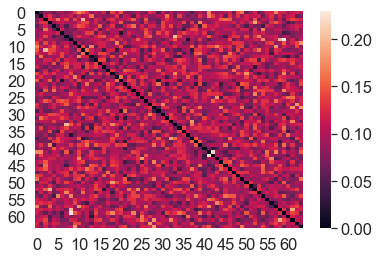

In [5]:
pattern_overlap = ps.pattern_overlap_matrix(memories)
sns.heatmap(pattern_overlap);

<AxesSubplot:title={'center':'transition matrix'}>

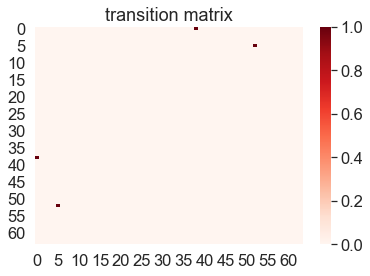

In [6]:
G = nx.from_numpy_matrix(memories.chain_transitions)
plt.title('transition matrix')
sns.heatmap(memories.chain_transitions,cmap=plt.cm.Reds)

In [7]:
memories.chains

[[0, 38], [5, 52]]

In [52]:
n_steps = 50

data = {'start':[],'condition':[],'retrieval_probability':[]}


for i in tqdm(range(len(memories.patterns))):
    starting_map = i
    net = nt.Network(J=memories.interaction_matrix, 
                    transfer_func=nt.ReLu,
                    dynamic_func=nt.net_dynamics)

    initial_config = ps.build_correlated_activity(memories,starting_map,position=0.1)
    net.run_dynamics(initial_config,n_steps=100,sparsity=DYNAMIC_SPARISTY)

    order_params_tracker = OrderParameterCalculator(memories=memories,network=net)
    on_rp = order_params_tracker.compute_on_chain_retrieval_probability()
    off_rp = order_params_tracker.compute_off_chain_retrieval_probability()

    coherence = order_params_tracker.coherence_timecourse

    chain_patterns = [j for sub in memories.chains for j in sub]

    if i in chain_patterns:
        data['start'] += ['on_chain','on_chain']
        data['condition'] += ['on_chain','off_chain']
        data['retrieval_probability'] += [on_rp,off_rp]

    else:
        data['start']+= ['off_chain','off_chain']
        data['condition'] += ['on_chain','off_chain']
        data['retrieval_probability'] += [on_rp,off_rp]


data = pd.DataFrame(data)

                


100%|██████████| 64/64 [21:47<00:00, 20.43s/it]  


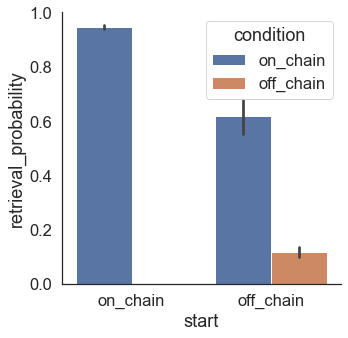

In [56]:
plt.figure(figsize=(5,5))
sns.barplot(data=data,x='start',y='retrieval_probability',hue='condition')
sns.despine()

# Plot dynamics examples

In [81]:
starting_map = 40
net = nt.Network(J=memories.interaction_matrix, 
                transfer_func=nt.ReLu,
                dynamic_func=nt.net_dynamics)

initial_config = ps.build_correlated_activity(memories,starting_map,position=0.1)
net.run_dynamics(initial_config,n_steps=n_steps,sparsity=DYNAMIC_SPARISTY)

order_params_tracker = OrderParameterCalculator(memories=memories,network=net)
on_rp = order_params_tracker.compute_on_chain_retrieval_probability()
off_rp = order_params_tracker.compute_off_chain_retrieval_probability()

coherence = order_params_tracker.coherence_timecourse
attractors = order_params_tracker.attractors_timecourse
retrieved_sequence = order_params_tracker.retrieved_sequence



Text(0, 0.5, 'pattern coherence')

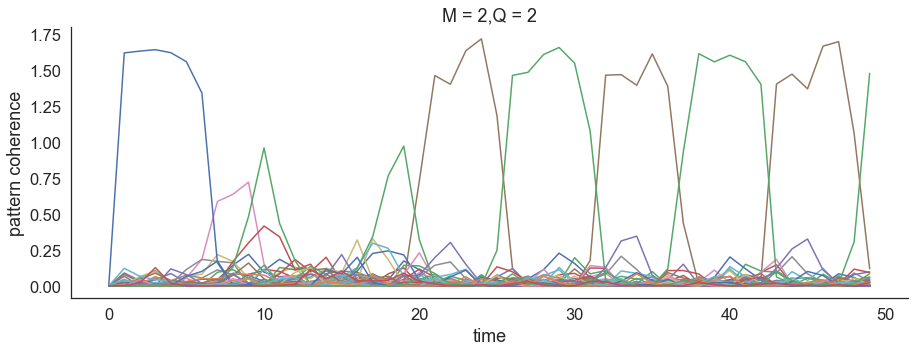

In [82]:
#retrieval_quality = fs.compute_retrieval_quality(coherence)
#obedience = fs.compute_obedience(retrieved_sequence,memories.chain_transitions)

plt.figure(figsize=(15,5))
for i,timecourse in enumerate(coherence):
    plt.plot(timecourse,label=f'pattern {i}')

sns.despine()
plt.title(f'M = {N_CHAINS},Q = {PATTERNS_PER_CHAIN}')
plt.xlabel('time')
plt.ylabel('pattern coherence')